# 2.1神经网络学习机制
- 数据预处理
- 模型设计
- 损失函数和优化方案设计
- 前向传播
- 反向传播
- 更新参数

# 2.2深度学习在实现上的特殊性
- 样本量大，通常需要分批（batch）加载
- 逐层、模块化搭建网络（卷积层、全连接层、LSTM等）
- 多样化的损失函数和优化设计
- GPU的使用(并行计算）
- 以上各个模块之间的配合

# 2.3PyTorch深度学习模块
- 基本配置
- 数据读入
- 模型构建
- 损失函数
- 优化器
- 训练与评估

## FashionMNIST时装分类
- 十类图片
- 32*32px

### 基本配置
- 导入必要的packages：os、numpy、torch、torch.nn、torch.optim、torch.utils.data
- 配置训练过程的超参数：batch_size、learning_rate、max_epochs、num_workers
- 配置训练用的硬件设备：CPU or GPU、which GPU(S)

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader

In [2]:
#配置GPU
##方案一：使用os.environ
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
#方案二：使用“device”,后续要对使用的GPU的变量用.to(device)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

##配置其他超参数
batch_size = 256
num_workers = 4 #有多少个线程共cpu读入数据
lr = 1e-4
epochs = 20

### 数据读入和加载
- 如何读取个数不定的本地数据：Dataset：__init__,__getitem__,__len__
- 如何将数据加载以供模型读入：DataLoader：batch_size,num_workers,shuffle,drop_last,pin_memory

In [3]:
# 首先设置数据变换
from torchvision import transforms

image_size = 28
data_transform = transforms.Compose([
#     transforms.ToPILImage(),  #第一步取决于后续的数据读取方式，如果使用内置的数据集则不需要
    transforms.Resize(image_size),
    transforms.ToTensor()
])

In [4]:
## 读取方式一：使用torchvision自带的数据集，下载可能需要一些时间
from torchvision import datasets

train_data = datasets.FashionMNIST(root = './',train = True,download = True,transform = data_transform)
test_data = datasets.FashionMNIST(root = './',train = False,download = True,transform = data_transform)

In [17]:
## 读取方式二： 读入csv格式的数据，自行构建Dataset类
# csv数据下载链接：https;//www.kaggle.com/zalando-research/fashionmnist
class FMDataset(Dataset):
    def __init__(self,df,trandform = None):
        self.df = df
        self.trandform = trandform
        self.images = df.iloc[:,1:].values.astype(np.uint8)
        self.labels = df.iloc[:,0].values
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx): #将csv每行的值转变为28*28*1的图片
        image = self.images[idx].reshape(28,28,1) #强行加一个通道数
        label = int(self.labels[idx])
        if trandform is not None:
            image = self.trandform(image)
        else:
            image = torch.tensor(image/255.,dtype = torch.float)
        label = torch.tensor(label,dtype = torch.long)
        return image,label
train_df = pd.read_csv('./FashionMNIST/fashion-mnist_train.csv')
test_df = pd.read_csv('./FashionMNIST/fashion-mnist_test.csv')
#FMDataset实例化
train_data = FMDataset(train_df,data_transform)
test_data = FMDataset(test_df,data_transform)

NameError: name 'train_df' is not defined

- 在构建训练集和测试集完成后，需要定义DataLoader类，以便在训练和测试时加载数据

In [5]:
train_loader = DataLoader(train_data,batch_size = batch_size,shuffle = True,num_workers = num_workers,drop_last = True)#是否读取最后一个数据，树模型通常不用最后一个数据
test_loader = DataLoader(test_data,batch_size = batch_size,shuffle = False,num_workers = num_workers)

- pin_memory ：可以让程序运行的更快，拿空间换时间

In [7]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


torch.Size([256, 1, 28, 28]) torch.Size([256])


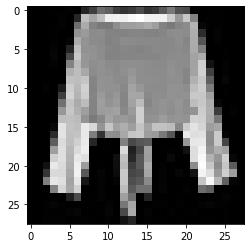

In [6]:
#读入数据进行可视化操作，验证数据读入是否正确
import matplotlib.pyplot as plt
image,label = next(iter(train_loader)) #不断向下迭代数据
print(image.shape,label.shape) #256：batch_size的大小
plt.imshow(image[0][0],cmap = 'gray')

### 模型构建
- 神经网络的构建：基于nn.Model（__init__,forward）
- 神经网络是通过“层定义+层顺序”的方式构建起来的
- 神经网络常见层：nn.Conv2d,nn.MaxPool2d,nn.Linear,nn.ReLU,... 

In [7]:
#模型设计：手搭CNN，用GPU进行训练
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv = nn.Sequential( #惯序模型：已经有网络层的顺序
            nn.Conv2d(1,32,5),
            nn.ReLU(), #激活函数
            nn.MaxPool2d(2,stride=2),#池化
            nn.Dropout(0.3),
            nn.Conv2d(32,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2,stride = 2),
            nn.Dropout(0.3)
#             Dropout是指在模型训练时随机让网络某些隐含层节点的权重不工作，不工作的那些节点可以暂时认为不是网络结构的一部分，
#             但是它的权重得保留下来（只是暂时不更新而已），因为下次样本输入时它可能又得工作了。   
#             训练神经网络模型时，如果训练样本较少，为了防止模型过拟合，Dropout可以作为一种trikc供选择。
        )
        #全连接层
        self.fc = nn.Sequential(
            nn.Linear(64*4*4,512), #从64*4*4的神经元到512个神经元
            nn.ReLU(),
            nn.Linear(512,10) #10类图片
        )
    def forward(self,x): #前馈
        x = self.conv(x) #输入卷积层
        x = x.view(-1,64*4*4) #维度变换，拉直操作
        x = self.fc(x) #64*4*4维的数据变为10维进行输出
        
        return x
model = Net()
model = model.cuda()
# model = nn.DataParallel(model).cuda() #多卡训练时的写法

In [15]:
?nn.Conv2d

### 损失函数
- torch.nn提供了多种预定义的损失函数
- 可以自己定义损失函数
- 根据实际需求选取对应的损失函数
- 损失函数常用操作：backward()

### 设定损失函数
- 使用torch.nn模块自带的CrossEntropy损失
- pytorch会自动把整数型的label转换为one-hot型，用于计算CE loss
- 这里需要确保label是从0开始，同时模型不加softmax层(使用logits计算)，这也说明了pytorch训练中各个部分不是独立的，需要通盘考虑

In [8]:
criterion = nn.CrossEntropyLoss()
#可以给不同类加权重
# criterion = nn.CrossEntropyLoss(weight = [1,1,1,1,3,1,1,1,1,1])

### 优化器
- torch.optim提供了多种预定义的优化器
- 可以自己定义优化器
- 根据实际需求选取对应的损失函数
- 优化器常用操作： step(),zero_grad(),load_state_dict()

In [9]:
#Adam优化器
optimizer = optim.Adam(model.parameters(),lr = 0.001)

### 训练与评估
- 模型状态设置：model.train(),model.eval()
- 训练流程：读取、转换、梯度清零、输入、计算损失、反向传播、参数更新
- 验证流程：读取、转换、输入、计算损失、计算指标

### 训练和测试（验证）
两者的区别：
- 模型状态设置
- 是否需要初始化优化器
- 是否需要将loss传回网络
- 是否需要每步更新optimizer
此外，对于测试或者验证，可以计算分类准确率

In [10]:
def train(epoch):
    model.train()
    train_loss = 0
    for data,label in train_loader:
        data,label = data.cuda(),label.cuda()
        optimizer.zero_grad() #梯队会累加，所以梯度回传不需要累加
        output = model(data)
        loss = criterion(output,label)
        loss.backward()
        optimizer.step() #更新权重
        train_loss += loss.item()*data.size(0) #训练损失的叠加
    train_loss = train_loss/len(train_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch,train_loss))

In [11]:
def val(epoch):
    model.eval()
    val_loss = 0
    gt_labels = []
    pred_labels = []
    with torch.no_grad(): #不做梯度的计算，不存在梯度，所以不需要清零
        for data,label in test_loader:
            data,label = data.cuda(),label.cuda()
            output = model(data)
            preds = torch.argmax(output,1) #
            gt_labels.append(label.cpu().data.numpy())
            pred_labels.append(preds.cpu().data.numpy())
            loss = criterion(output,label)
            val_loss += loss.item()*data.size(0)
    val_loss = val_loss/len(test_loader.dataset)
    gt_labels,pred_labels = np.concatenate(gt_labels),np.concatenate(pred_labels)
    acc = np.sum(gt_labels == pred_labels)/len(pred_labels)
    print('Epoch: {} \tValidation Loss: {:.6f},Accuracy: {:.6f}'.format(epoch,val_loss,acc)) 

In [12]:
for epoch in range(1,epochs+1):
    train(epoch)
    val(epoch)

Epoch: 1 	Training Loss: 0.652716
Epoch: 1 	Validation Loss: 0.443665,Accuracy: 0.837600
Epoch: 2 	Training Loss: 0.413911
Epoch: 2 	Validation Loss: 0.357751,Accuracy: 0.871700
Epoch: 3 	Training Loss: 0.354646
Epoch: 3 	Validation Loss: 0.321965,Accuracy: 0.883600
Epoch: 4 	Training Loss: 0.319467
Epoch: 4 	Validation Loss: 0.298579,Accuracy: 0.890300
Epoch: 5 	Training Loss: 0.296765
Epoch: 5 	Validation Loss: 0.292735,Accuracy: 0.894800
Epoch: 6 	Training Loss: 0.280536
Epoch: 6 	Validation Loss: 0.277010,Accuracy: 0.901600
Epoch: 7 	Training Loss: 0.265045
Epoch: 7 	Validation Loss: 0.271075,Accuracy: 0.904400
Epoch: 8 	Training Loss: 0.258741
Epoch: 8 	Validation Loss: 0.263781,Accuracy: 0.904200
Epoch: 9 	Training Loss: 0.248359
Epoch: 9 	Validation Loss: 0.250519,Accuracy: 0.907700
Epoch: 10 	Training Loss: 0.234053
Epoch: 10 	Validation Loss: 0.241821,Accuracy: 0.912800
Epoch: 11 	Training Loss: 0.226389
Epoch: 11 	Validation Loss: 0.238854,Accuracy: 0.913700
Epoch: 12 	Traini

In [13]:
gpu_info = !nvidia-smi -i 0
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Mon Sep 26 20:05:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.64       Driver Version: 471.80       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P8    N/A /  N/A |    895MiB /  2048MiB |    ERR!      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
### 模型保存